<a href="https://colab.research.google.com/github/Tirth-Modi/Chintu/blob/main/Students_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from pyngrok import ngrok

# Kill all existing ngrok tunnels
ngrok.kill()

print("✅ All existing ngrok tunnels stopped")


✅ All existing ngrok tunnels stopped


In [1]:
!pip install dagster dagster-webserver kagglehub pandas numpy scikit-learn matplotlib seaborn graphviz pyngrok -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.6/212.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207

In [2]:
!mkdir -p dagster_student_performance/assets
!touch dagster_student_performance/assets/__init__.py
!touch dagster_student_performance/__init__.py


In [3]:
import os
os.environ["DAGSTER_HOME"] = "/content/dagster_home"

!mkdir -p /content/dagster_home


In [4]:
%%writefile dagster_student_performance/assets/data.py
from dagster import asset
import kagglehub
import pandas as pd
import os

@asset
def raw_data():
    path = kagglehub.dataset_download("spscientist/students-performance-in-exams")
    csv_path = os.path.join(path, "StudentsPerformance.csv")
    df = pd.read_csv(csv_path)
    print(df.columns)
    return df


Writing dagster_student_performance/assets/data.py


In [5]:
%%writefile dagster_student_performance/assets/eda.py
from dagster import asset
import seaborn as sns
import matplotlib.pyplot as plt

@asset
def eda_heatmap(raw_data):
    df = raw_data.select_dtypes(include=["int64", "float64"])

    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap - Student Performance")
    plt.tight_layout()
    plt.show()

    return "EDA Heatmap Generated"


Writing dagster_student_performance/assets/eda.py


In [6]:
%%writefile dagster_student_performance/assets/features.py
from dagster import asset
from sklearn.model_selection import train_test_split
import pandas as pd

@asset
def features(raw_data):
    df = raw_data.copy()

    TARGET = "math score"
    y = df[TARGET]
    X = df.drop(columns=[TARGET])

    X = pd.get_dummies(X, drop_first=True)

    return train_test_split(X, y, test_size=0.2, random_state=42)


Writing dagster_student_performance/assets/features.py


In [7]:
%%writefile dagster_student_performance/assets/models.py
from dagster import asset
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

@asset
def model_dt(features):
    X_train, X_test, y_train, y_test = features
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds) ** 0.5

@asset
def model_knn(features):
    X_train, X_test, y_train, y_test = features
    model = KNeighborsRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds) ** 0.5

@asset
def model_lr(features):
    X_train, X_test, y_train, y_test = features
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds) ** 0.5

@asset
def model_rf(features):
    X_train, X_test, y_train, y_test = features
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds) ** 0.5

@asset
def model_comparison(model_dt, model_knn, model_lr, model_rf):
    results = {
        "Decision Tree": model_dt,
        "KNN": model_knn,
        "Linear Regression": model_lr,
        "Random Forest": model_rf,
    }

    print("\nMODEL RMSE COMPARISON")
    for model, rmse in results.items():
        print(f"{model}: {rmse:.2f}")

    best_model = min(results, key=results.get)
    print(f"\nBEST MODEL: {best_model}")

    return {
        "results": results,
        "best_model": best_model,
    }


Writing dagster_student_performance/assets/models.py


In [8]:
%%writefile dagster_student_performance/definitions.py
from dagster import Definitions

from dagster_student_performance.assets.data import raw_data
from dagster_student_performance.assets.eda import eda_heatmap
from dagster_student_performance.assets.features import features
from dagster_student_performance.assets.models import (
    model_dt,
    model_knn,
    model_lr,
    model_rf,
    model_comparison,
)

defs = Definitions(
    assets=[
        raw_data,
        eda_heatmap,
        features,
        model_dt,
        model_knn,
        model_lr,
        model_rf,
        model_comparison,
    ]
)


Writing dagster_student_performance/definitions.py


2026-02-02 15:46:24 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - RUN_START - Started execution of run for "__ephemeral_asset_job__".
2026-02-02 15:46:24 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - ENGINE_EVENT - Executing steps in process (pid: 411)
2026-02-02 15:46:24 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-02-02 15:46:24 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-02-02 15:46:24 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - LOGS_CAPTURED - Started capturing logs in process (pid: 411).
2026-02-02 15:46:24 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-4

Using Colab cache for faster access to the 'students-performance-in-exams' dataset.


2026-02-02 15:46:28 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - raw_data - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-02-02 15:46:28 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - raw_data - Writing file at: /tmp/tmp12uz3wdo/storage/raw_data using PickledObjectFilesystemIOManager...
2026-02-02 15:46:28 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - raw_data - ASSET_MATERIALIZATION - Materialized value raw_data.
2026-02-02 15:46:28 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - raw_data - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-02-02 15:46:28 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - raw_data - STEP_SUCCESS - Finished execution of step "raw_data" in 4.08s.
2026-02-02 1

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')


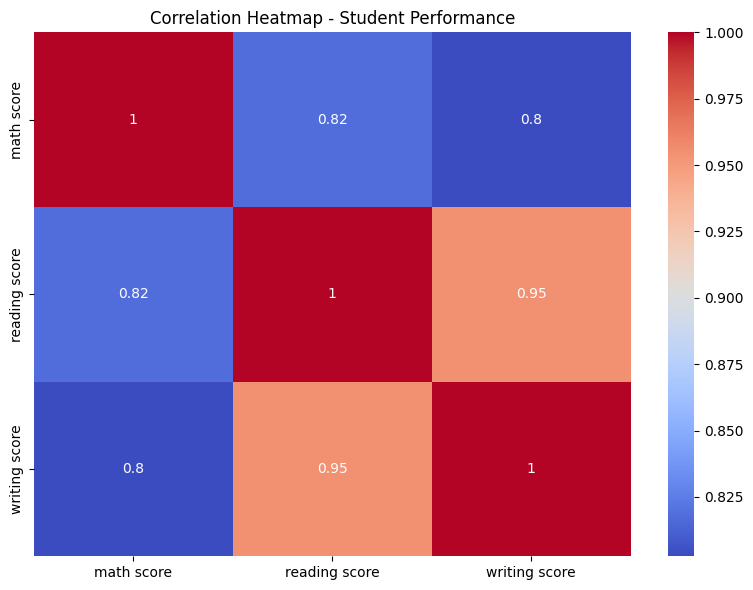

2026-02-02 15:46:29 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - eda_heatmap - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-02-02 15:46:29 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - eda_heatmap - Writing file at: /tmp/tmp12uz3wdo/storage/eda_heatmap using PickledObjectFilesystemIOManager...
2026-02-02 15:46:29 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - eda_heatmap - ASSET_MATERIALIZATION - Materialized value eda_heatmap.
2026-02-02 15:46:29 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - eda_heatmap - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-02-02 15:46:29 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 93a4d0b0-434a-4ac5-b5f6-cd3c102cfe43 - 411 - eda_heatmap - STEP_SUCCESS - Finished execution of step "eda_heatmap


MODEL RMSE COMPARISON
Decision Tree: 8.39
KNN: 8.65
Linear Regression: 5.39
Random Forest: 6.06

BEST MODEL: Linear Regression


In [9]:
import sys, os
sys.path.insert(0, os.getcwd())

from dagster import materialize
from dagster_student_performance.definitions import defs

result = materialize(defs.assets)
result


In [10]:
print("DT RMSE:", result.output_for_node("model_dt"))
print("KNN RMSE:", result.output_for_node("model_knn"))
print("LR RMSE:", result.output_for_node("model_lr"))
print("RF RMSE:", result.output_for_node("model_rf"))


DT RMSE: 8.389874850079709
KNN RMSE: 8.652467856051244
LR RMSE: 5.393993869732843
RF RMSE: 6.057693992701515


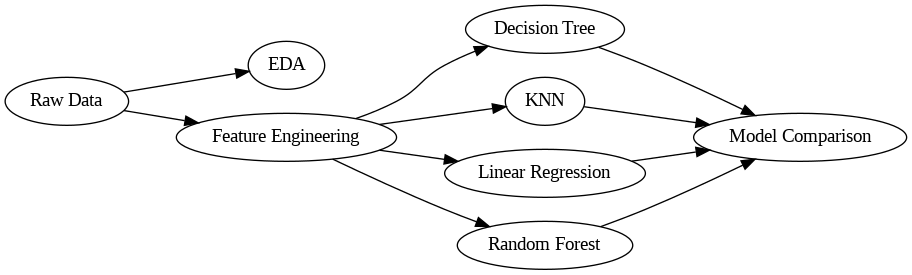

In [11]:
from graphviz import Digraph
from IPython.display import display, Image

g = Digraph(comment="Student Performance ML Pipeline", graph_attr={"rankdir": "LR"})

g.node("raw", "Raw Data")
g.node("eda", "EDA")
g.node("feat", "Feature Engineering")
g.node("dt", "Decision Tree")
g.node("knn", "KNN")
g.node("lr", "Linear Regression")
g.node("rf", "Random Forest")
g.node("cmp", "Model Comparison")

g.edges([
    ("raw", "eda"),
    ("raw", "feat"),
    ("feat", "dt"),
    ("feat", "knn"),
    ("feat", "lr"),
    ("feat", "rf"),
    ("dt", "cmp"),
    ("knn", "cmp"),
    ("lr", "cmp"),
    ("rf", "cmp"),
])

g.render("/mnt/data/student_pipeline", format="png", cleanup=True)
display(Image("/mnt/data/student_pipeline.png"))


In [17]:
# 🔄 Clean Dagster state
!rm -rf /content/dagster_home/*
!touch /content/dagster_home/dagster.yaml

# ❌ Kill anything on port 3000
!kill -9 $(lsof -t -i:3000) > /dev/null 2>&1 || true

# 🚀 Start Dagster
!nohup dagster dev -f dagster_student_performance/definitions.py > dagster.log 2>&1 &

# ⏳ Wait for server
!sleep 10

# 🌍 Start ngrok tunnel
from pyngrok import ngrok, conf

NGROK_AUTH_TOKEN = "397WonZpDMr6bpmcyw7QddrLpJg_4vAAtWvsCcwQbL8cf7GyR"
conf.get_default().auth_token = NGROK_AUTH_TOKEN

# Kill all existing ngrok tunnels again to be sure
ngrok.kill()

ngrok_tunnel = ngrok.connect(3000)
print("✅ Dagster UI:", ngrok_tunnel.public_url)

✅ Dagster UI: https://cofinal-nonoriginally-danyel.ngrok-free.dev
